## Text Analytics

### Sentiment Analysis (Bags of Words model)
The frequency which with words appear play a role. The order does not matter.

Steps:
- Create document x term matrix.
- For each document, count how many of each term appears
- Preprocess by removing common copulars, pronouns, articles, conjuctives, etc.
- Preprocess by lowercasing all words??
- Preprocess by using N-grams
- Preprocess by removing punctuations
- Preprocess by stemming words to their cognates (Porter stemming algo)

All preprocessing steps can be doe with several R packages, including `"tm"`

### Preprocessing

In [5]:
twitter <- read.csv("csv/twitter.csv", stringsAsFactors = F) # prevents strings from being automatically read as factors
str(twitter) # sentiments 1,2,4,5 - 5 = v. positive, 1= v. negative (why no sentiment 3 ??)
head(twitter)

'data.frame':	2664 obs. of  2 variables:
 $ sentiment: int  5 5 5 5 5 5 5 5 5 5 ...
 $ tweet    : chr  "Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!" "Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv" "Autonomous vehicles could reduce traffic fatalities by 90%...I'm in!" "Really good presentation from Jan Becker on Bosch's automated vehicle research. #AutoAuto check it out" ...


sentiment,tweet
5,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
5,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv
5,Autonomous vehicles could reduce traffic fatalities by 90%...I'm in!
5,Really good presentation from Jan Becker on Bosch's automated vehicle research. #AutoAuto check it out
5,Ford just revealed it's Automated Ford Fusion Hybrid Vehicle. Pretty amazing. #fordtrends @ Ford Test http://t.co/7axya8ogIW
5,"So yeah, just throwing this out there again. Would totally be down to beta test an autonomous car."


For now, let us do binary classification. We will look at multiclass classfication later.

In [9]:
twitter$Negative <- as.factor(twitter$sentiment <= 2)
table(twitter$Negative)
# there are 775 negative tweets...


FALSE  TRUE 
 1889   775 

Now, we want to structure our text strings to make them easy to process, to do this we will enlist the help of 3rd-party packages.

In [83]:
# install.packages("tm")
# install.packages("SnowballC")
library(tm)

# preprocessing to get around Linux string formatting bug
# apply proper encoding for columns with datatype `string`
twitter[,sapply(twitter,is.character)] <- sapply(
    twitter[,sapply(twitter,is.character)],
    iconv,"WINDOWS-1252","UTF-8")

# ?Corpus
# create new corpus (structured database of text strings)
corpus <- Corpus(VectorSource(twitter$tweet))
corpus
corpus[[1]]
as.character(corpus[[1]])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 2664

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 83

[1] "Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!"

In [84]:
# lowercasing all words
corpus <- tm_map(corpus, tolower)
as.character(corpus[[1]])

# dropping common pronouns, conjunctives, etc.
# stopwords("english") # check what are the stopwords defined in the package
corpus <- tm_map(corpus, removeWords, stopwords("english"))
as.character(corpus[[1]])

# dropping custom stopwords
corpus <- tm_map(corpus, removeWords, c("drive", "driving", "driver", "self-driving", "car", "cars"))
as.character(corpus[[1]])

# remove punctuations
corpus <- tm_map(corpus, removePunctuation)
as.character(corpus[[1]])

# stemming words
corpus <- tm_map(corpus, stemDocument)
as.character(corpus[[1]])
as.character(corpus[[3]])

# you can also further remove numbers if you wish, depending on problem setting
# we may want to preserve emoji as well if our problem context has a significant number of them

[1] "two places i'd invest all my money if i could: 3d printing and self-driving cars!!!"

[1] "two places  invest   money   : 3d printing  self-driving cars!!!"

[1] "two places  invest   money   : 3d printing   !!!"

[1] "two places  invest   money    3d printing   "

[1] "two place invest money 3d print"

[1] "autonom vehicl reduc traffic fatal 90"

Now, we will convert that corpus database automatically into a document-term matrix.

In [56]:
freq <- DocumentTermMatrix(corpus)
freq # note that sparsity=100%

inspect(freq[1,])
findFreqTerms(freq, lowfreq=50)
freq[,"accid"] # there are 63 non-zero entries for `accident`

<<DocumentTermMatrix (documents: 2664, terms: 5523)>>
Non-/sparse entries: 21663/14691609
Sparsity           : 100%
Maximal term length: 7704
Weighting          : term frequency (tf)

<<DocumentTermMatrix (documents: 1, terms: 5523)>>
Non-/sparse entries: 5/5518
Sparsity           : 100%
Maximal term length: 7704
Weighting          : term frequency (tf)
Sample             :
    Terms
Docs awesom blind driverless googl help invest money place print two
   1      0     0          0     0    0      1     1     1     1   1


[1] "awesom"     "driverless" "googl"      "will"       "autonom"   
 [6] "traffic"    "vehicl"     "good"       "realli"     "just"      
[11] "now"        "wait"       "cool"       "technolog"  "first"     
[16] "futur"      "road"       "say"        "year"       "human"     
[21] "make"       "one"        "accid"      "time"       "want"      
[26] "think"      "thing"      "new"        "saw"        "can"       
[31] "get"        "love"       "see"        "come"       "use"       
[36] "street"     "way"        "great"      "via"        "uber"      
[41] "today"      "take"       "wheel"      "ride"       "like"      
[46] "need"       "peopl"      "look"       "amp"        "driver"    
[51] "self"       "california" "work"       "robot"

<<DocumentTermMatrix (documents: 2664, terms: 1)>>
Non-/sparse entries: 63/2601
Sparsity           : 98%
Maximal term length: 5
Weighting          : term frequency (tf)

Now, the next thing we do is to remove terms that occur with too few observations, since to use them to predict sentiment will be challenging, or outright inaccurate.

In [60]:
freq <- removeSparseTerms(freq, 0.995) # remove terms with at least 99.5% sparsity
freq

<<DocumentTermMatrix (documents: 2664, terms: 257)>>
Non-/sparse entries: 11574/673074
Sparsity           : 98%
Maximal term length: 10
Weighting          : term frequency (tf)

`freq` is now a fully preprocessed document-term matrix with 2664 documents and 257 terms.

In [68]:
twittersparse <- as.data.frame(as.matrix(freq))
# str(twittersparse)
head(twittersparse)

# ensure names are well-defined for columns
# e.g. var names cannot start with numbers in any programming language
colnames(twittersparse) <- make.names(colnames(twittersparse))

# include y-var in new dataframe
twittersparse$Neg <- twitter$Negative
head(twittersparse)

money,place,two,awesom,driverless,googl,help,will,autonom,reduc,⋯,sure,fleet,crash,safe,kill,abl,part,thought,mayb,worri
1,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,1,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


money,place,two,awesom,driverless,googl,help,will,autonom,reduc,⋯,fleet,crash,safe,kill,abl,part,thought,mayb,worri,Neg
1,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,1,1,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,FALSE


Now, we're done! We can now apply any of our preferred prediction technique for predicting sentiment of each tweet!

### Building simple model (logistic regression)

Now, let us build a baseline logistic regression model to see the results

In [85]:
library(caTools)
set.seed(123)
spl <- sample.split(twittersparse$Neg, SplitRatio=0.7)
train <- subset(twittersparse, spl==T)
test <- subset(twittersparse, spl==F)

In [74]:
model1 <- glm(Neg~., data=train, family=binomial)
summary(model1)

# warning message due to floating point precision errors

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = Neg ~ ., family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4289  -0.6886  -0.2697   0.4826   2.9667  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.173e-01  1.515e-01  -3.413 0.000642 ***
money        6.682e-02  9.659e-01   0.069 0.944849    
place        1.074e+00  1.042e+00   1.031 0.302544    
two          3.958e-01  8.361e-01   0.473 0.635927    
awesom      -3.130e+00  1.095e+00  -2.858 0.004269 ** 
driverless   5.470e-01  1.737e-01   3.149 0.001636 ** 
googl       -2.438e-01  1.442e-01  -1.691 0.090913 .  
help        -8.099e-02  8.797e-01  -0.092 0.926641    
will        -1.833e-01  2.357e-01  -0.778 0.436722    
autonom      2.428e-01  4.080e-01   0.595 0.551788    
reduc       -2.635e+00  1.322e+00  -1.994 0.046191 *  
traffic     -1.530e+00  7.963e-01  -1.921 0.054700 .  
vehicl      -5.735e-01  4.034e-01  -1.422 0.155062    
check       -1.668e+01  1.043e+03  -0.

Note that the predictor variable `awesom` is -3.130, which is reasonable since if the word `awesome` appears, the tweet can be said to be a positive sentiment tweet. More relevant coeffs:

- `accid`: 1.208
- `amaz`: -1.734
- `dont`: 4.479

In [81]:
threshold = 0.5
predict1 <- predict(model1, test, type="response")
table(predict1>=threshold, test$Neg)

# accuracy
(483+107)/(483+107+84+126)

       
        FALSE TRUE
  FALSE   483  126
  TRUE     84  107

[1] 0.7375

### Building more sophisticated models (CART)

Now, we are going to build a classification tree.

Call:
rpart(formula = Neg ~ ., data = train)
  n= 1864 

          CP nsplit rel error    xerror       xstd
1 0.02214022      0 1.0000000 1.0000000 0.03617372
2 0.01845018      1 0.9778598 0.9907749 0.03607450
3 0.01660517      2 0.9594096 0.9704797 0.03585079
4 0.01000000      3 0.9428044 0.9649446 0.03578846

Variable importance
  job point trust 
   40    30    30 

Node number 1: 1864 observations,    complexity param=0.02214022
  predicted class=FALSE  expected loss=0.2907725  P(node) =1
    class counts:  1322   542
   probabilities: 0.709 0.291 
  left son=2 (1850 obs) right son=3 (14 obs)
  Primary splits:
      job   < 0.5 to the left,  improve=11.476240, (0 missing)
      trust < 0.5 to the left,  improve= 8.527087, (0 missing)
      point < 0.5 to the left,  improve= 8.460918, (0 missing)
      wait  < 0.5 to the right, improve= 8.192832, (0 missing)
      cool  < 0.5 to the right, improve= 8.020873, (0 missing)

Node number 2: 1850 observations,    complexity param=0.018450

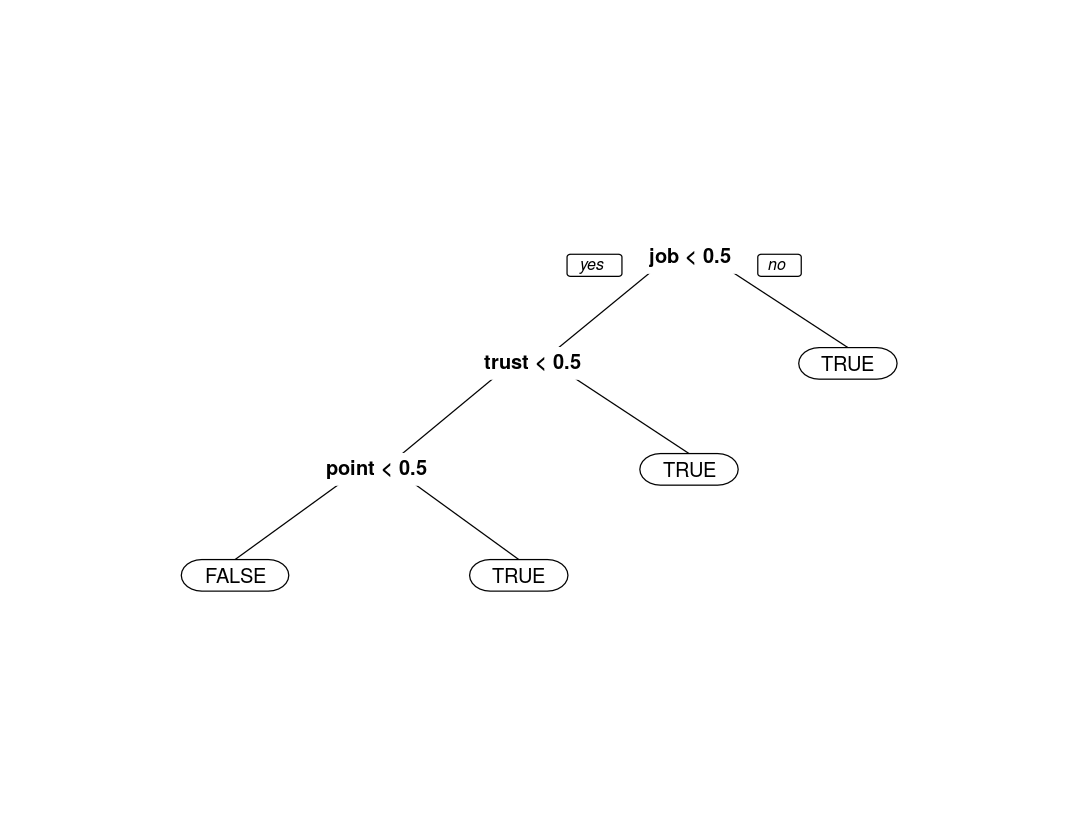

In [121]:
library(rpart)
set.seed(111)
model2 <- rpart(Neg~., train)
summary(model2)

# plotting model
options(repr.plot.width=9, repr.plot.height=7) # resize IRkernel plot size
library(rpart.plot)
prp(model2)

Compared with `Model`, we get an accuracy of 72.1% with CART, as opposed to 73.8% in logistic regression.

In [101]:
# prediction using classification tress
predict2 <- predict(model2, test, type="class")
table(predict2, test$Neg)

# accuracy of CART
(561+16)/(561+16+6+217)

        
predict2 FALSE TRUE
   FALSE   561  217
   TRUE      6   16

[1] 0.72125

Now, we might want to build a deeper tree.

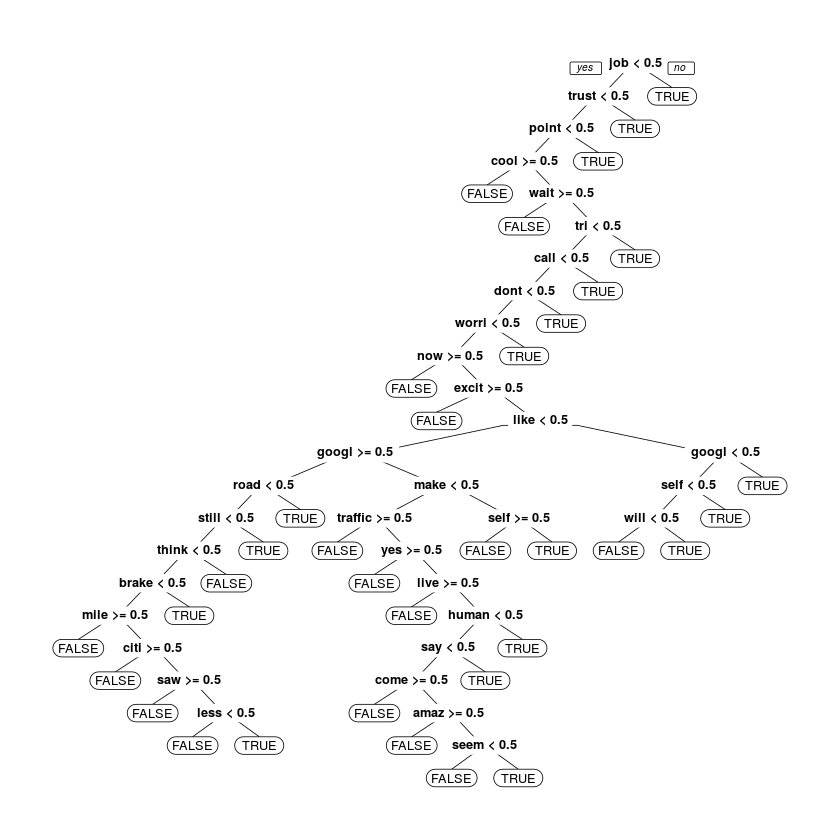

In [108]:
set.seed(123)
model2b <- rpart(Neg~., train, cp=10^-6)
# summary(model3)
prp(model2b)

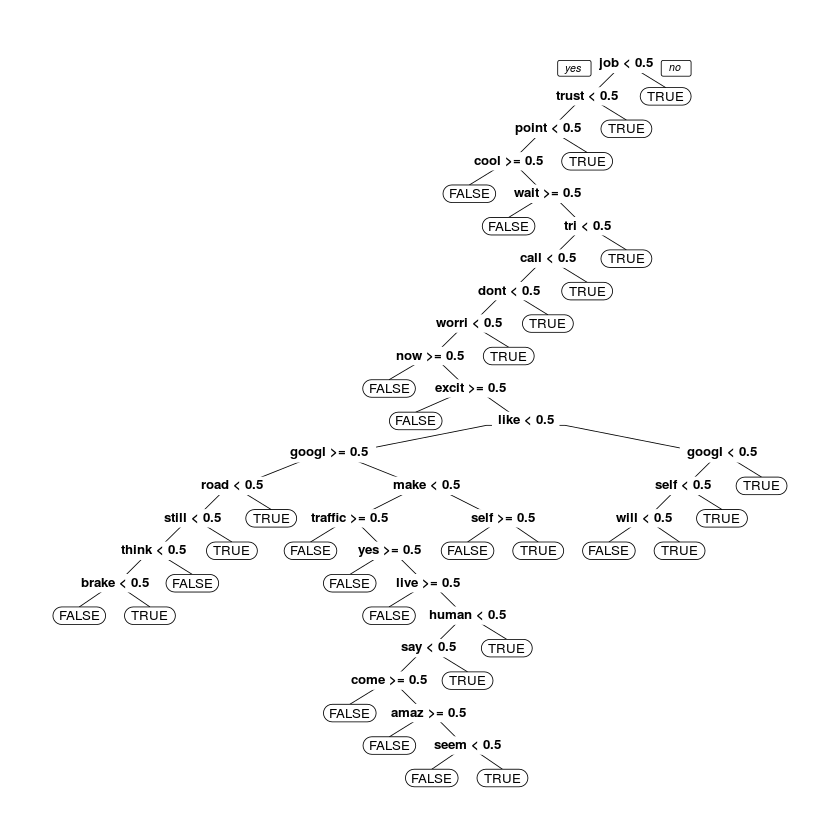

In [109]:
# pruning model2
model2c <- prune(model2b, cp=0.0009)
prp(model2c)`

We can observe that the accuracy of 71.6% is an even worse result.

In [112]:
predict2c <- predict(model2c, test, type="class")
table(predict2c, test$Neg)

# accuracy of prunes tree from `model2b`
(521+52)/(521+52+46+181)

         
predict2c FALSE TRUE
    FALSE   521  181
    TRUE     46   52

[1] 0.71625

### Building more sophisticated models (Random forests)

OOB is the out-of-sample error (i.e., prediction error rate on test set based on model trained on training set)

In [113]:
library(randomForest)
set.seed(112)
model3 <- randomForest(Neg~., train)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [114]:
model3


Call:
 randomForest(formula = Neg ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 16

        OOB estimate of  error rate: 27.41%
Confusion matrix:
      FALSE TRUE class.error
FALSE  1147  175   0.1323752
TRUE    336  206   0.6199262

In [120]:
## compare sccuracy with prediction on training vs test set
predict3a <- predict(model3, train, type="class")
predict3b <- predict(model3, test, type="class")

table(predict3a, train$Neg) # accuracy is 94% !!
table(predict3b, test$Neg) # accuracy is ~75%

         
predict3a FALSE TRUE
    FALSE  1306  103
    TRUE     16  439

         
predict3b FALSE TRUE
    FALSE   494  135
    TRUE     73   98